# L1c: k-Means Clustering Analysis of a Heart Failure Clinical Dataset
Fill me in

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.

In [3]:
include("Include.jl");

Next, let's load up the data set that we will explore. This data was taken from the publication:
* [Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone." BMC Medical Informatics and Decision Making 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5](https://pubmed.ncbi.nlm.nih.gov/32013925/)

In this paper, the authors analyzed a dataset of 299 heart failure patients collected in 2015. The patients comprised 105 women and 194 men, aged between 40 and 95 years old. The dataset contains 13 features (a mixture of continuous and categorical data), which report clinical, body, and lifestyle information:
* Some features are binary: anemia, high blood pressure, diabetes, sex, and smoking status.
* The remaining features were continuous biochemical measurements, such as the Level of the Creatinine phosphokinase (CPK) enzyme in the blood, the number of platelets, etc.
* The class (target) variable is encoded as a binary (boolean) death event: `1` if the patient died during the follow-up period, `0` otherwise.

We'll load this data as a [DataFrame instance](https://dataframes.juliadata.org/stable/) and store it in the `originaldataset::DataFrame` variable:

In [5]:
originaldataset = CSV.read(joinpath(_PATH_TO_DATA, "heart_failure_clinical_records_dataset.csv"), DataFrame)

Row,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64
1,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4,1
2,55.0,0,7861,0,38,0,263358.0,1.1,136,1,0,6,1
3,65.0,0,146,0,20,0,162000.0,1.3,129,1,1,7,1
4,50.0,1,111,0,20,0,210000.0,1.9,137,1,0,7,1
5,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
6,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8,1
7,75.0,1,246,0,15,0,127000.0,1.2,137,1,0,10,1
8,60.0,1,315,1,60,0,454000.0,1.1,131,1,1,10,1
9,65.0,0,157,0,65,0,263358.0,1.5,138,0,0,10,1


In [6]:
D = let

    # convert 0,1 into -1,1
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :anaemia => ByRow(x -> (x==0 ? -1 : 1)) => :anaemia); # maps anaemia to -1,1
    transform!(treated_dataset, :diabetes => ByRow(x -> (x==0 ? -1 : 1)) => :diabetes); # maps diabetes to -1,1
    transform!(treated_dataset, :high_blood_pressure => ByRow(x -> (x==0 ? -1 : 1)) => :high_blood_pressure); # maps high_blood_pressure to -1,1
    transform!(treated_dataset, :sex => ByRow(x -> (x==0 ? -1 : 1)) => :sex); # maps sex to -1,1
    transform!(treated_dataset, :smoking => ByRow(x -> (x==0 ? -1 : 1)) => :smoking); # maps smoking to -1,1
    transform!(treated_dataset, :death_event => ByRow(x -> (x==0 ? -1 : 1)) => :death_event); # maps death_event to -1,1
    
    D = treated_dataset[:,1:end] |> Matrix; # build a data matrix
    (number_of_examples, number_of_features) = size(D);

    # Which cols do we want to rescale?
    index_to_scale = [
        1 ; # 1 age
        3 ; # 2 creatinine_phosphokinase
        5 ; # 3 ejection_fraction
        7 ; # 4 platelets
        8 ; # 5 serum_creatinine
        9 ; # 6 serum_sodium
        12 ; # 7 time
    ];

    D̂ = copy(D);
    for i ∈ eachindex(index_to_scale)
        j = index_to_scale[i];
        μ = mean(D[:,j]); # compute the mean
        σ = std(D[:,j]); # compute std

        # rescale -
        for k ∈ 1:number_of_examples
            D̂[k,j] = (D[k,j] - μ)/σ;
        end
    end

    # remove categorical cols -
    D̂₂ = D̂[:,index_to_scale];
    #D̂₂ = D̂;
    
    D̂₂
end;

In [7]:
D

299×7 Matrix{Float64}:
  1.19095     0.000165451  -1.528       …   0.489237    -1.50152    -1.62678
 -0.490457    7.50206      -0.00706491     -0.284076    -0.141739   -1.60101
  0.350246   -0.449186     -1.528          -0.0907479   -1.72815    -1.58812
 -0.910808   -0.485257     -1.528           0.489237     0.0848915  -1.58812
  0.350246   -0.434757     -1.528           1.26255     -4.67434    -1.57524
  2.452      -0.551217      0.161928    …   0.682565    -1.04826    -1.57524
  1.19095    -0.346124     -1.95048        -0.187412     0.0848915  -1.54947
 -0.0701056  -0.275011      1.85185        -0.284076    -1.27489    -1.54947
  0.350246   -0.437849      2.27433         0.10258      0.311522   -1.54947
  1.6113     -0.47289      -0.260554        7.73905     -0.821629   -1.54947
  1.19095    -0.516176     -0.00706491  …   2.51918     -1.27489    -1.54947
  0.098035   -0.361583     -1.10552        -0.477404     0.764782   -1.54947
 -1.33116     0.411384     -0.683035       -0.284076 

Let's set some constants that we'll need in the examples below. See the comment next to the constant for a description of what it is, it's permissible values, etc.

In [9]:
n = nrow(originaldataset); # how many example data points do we have?
m = size(D,2); # number of features (number of cols)
maxiter = 10000; # maximum iterations
K = 2; # number of clusters. What number should we pick?
ϵ = 1e-6; # tolerance for termination. We can set this to whatever we want

Finally, let's set up the color dictionary for the visualizations in the lecture. The keys of the `my_color_dictionary::Dict{Int64,RGB}` dictionary are the cluster indexes, while the values are the colors mapped to that index.

In [11]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e";
my_color_dictionary[2] = colorant"#0077b6";
my_color_dictionary[3] = colorant"#00b4d8";
my_color_dictionary[4] = colorant"#ffc300";
my_color_dictionary[5] = colorant"#e36414";

## Task 1: Build the k-means model and cluster the data
We've developed an [initial k-means implementation](src/Cluster.jl) based on [our pseudo-code](figs/pcode-kmeans.pdf). Let's explore how this implementation performs on our sample dataset. 
* Build [a `MyNaiveKMeansClusteringAlgorithm` instance](src/Types.jl), which holds information about the clustering, i.e., the number of clusters `K::Int,` information about the dataset such as the number of features `m::Int,` and the number of points `n::Int,` and stopping criteria information such as the maximum number of iterations `maxiter::Int` and tolerance `ϵ::Float64`. We'll store this model in the `model::MyNaiveKMeansClusteringAlgorithm` variable.
* This is an example of [a factory type pattern](https://en.wikipedia.org/wiki/Factory_method_pattern), which uses [a `build(...)` method](src/Factory.jl) to construct and configure a complex object, i.e., set values for the properties on the model that must be computed. The [`build(...)` method](src/Factory.jl) takes the type of thing we want to build as the first argument, and the data required to construct the object (encoded [in a `NamedTupe` type](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple)) as the second argument.

In [13]:
model = build(MyNaiveKMeansClusteringAlgorithm, (
        maxiter = maxiter,
        dimension = m,
        number_of_points = n,
        K = K,
        ϵ = ϵ,
        scale_factor = 1.0, # scale of the data
));

In [14]:
model.centroids

Dict{Int64, Vector{Float64}} with 2 entries:
  2 => [0.291817, 0.450308, 0.30335, 0.425007, 0.845734, 0.218181, 0.39318]
  1 => [0.590409, 0.0367457, 0.0257898, 0.0605897, 0.139897, 0.987525, 0.902779]

The `model::MyNaiveKMeansClusteringAlgorithm` contains the data that we passed in and two derived fields that we computed in [the `build(...)` method](src/Factory.jl):
* The `centroids::Dict{Int64, Vector{Float64}}` dictionary holds the centroid values $\mu_{1},\dots,\mu_{K}$ for each cluster. The dictionary's keys are the cluster index, while the values are the `m`-dimensional centroids (means) of the data points in that cluster. We initialize the centroids randomly.
* The `assignments::Vector{Int64}` field is an `n`-dimensional vector holding the cluster index that each data point is assigned to. We initialize the assignments randomly.

In [16]:
model.centroids

Dict{Int64, Vector{Float64}} with 2 entries:
  2 => [0.291817, 0.450308, 0.30335, 0.425007, 0.845734, 0.218181, 0.39318]
  1 => [0.590409, 0.0367457, 0.0257898, 0.0605897, 0.139897, 0.987525, 0.902779]

### Execute the clustering
We call [the `cluster(...)` method](src/Cluster.jl) to refine our initial random cluster assignments and centroid values. The [`cluster(...)` method](src/Cluster.jl) takes a few arguments:

* `D::Array{<:Number, 2}`: The first argument is the data matrix `D::Array{<:Number,2}` which we want to cluster. The data matrix has the features along the columns, and each row is a data (feature) vector $\mathbf{x}$. Its values can be any type that is a subtype [of Number](https://docs.julialang.org/en/v1/base/numbers/#Core.Number). 
* `model::<: MyAbstractUnsupervisedClusteringAlgorithm`: The second argument is the cluster model instance, in this case, the `model::MyNaiveKMeansClusteringAlgorithm` instance that we built above. However, this can be any subtype of ` MyAbstractUnsupervisedClusteringAlgorithm.`
    * __Why?__ Suppose we have different k-means implementations or different clustering logic altogether. In that case, we can take advantage of Julia's multiple dispatch functionality by passing in a different clustering model. This provides a single method for a user to call, which calls a different implementation.
* `verbose::Bool`: The `verbose::Bool` argument tells our implementation whether to save data from each algorithm iteration. The default value is `false`. However, if the value is set to `true,` a save file holding the assignments, centroids, and loop index is written at each iteration.
* `d::Any`. The optional distance argument can change how the similarity between feature vectors $\mathbf{x}\in\mathcal{D}$ is calculated. We can use [any metrics exported by the `Distances.jl` package](https://github.com/JuliaStats/Distances.jl); by default, we [use the Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance). 

The [`cluster(...)` method](src/Cluster.jl) returns cluster centroids, the assignments, and the number of iterations that it took to reach the final assignment in the `results::NamedTuple.`

In [18]:
result = cluster(D, model, verbose = false); # cluster the data

In [19]:
result.assignments

299-element Vector{Int64}:
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [20]:
result.centroids

Dict{Int64, Vector{Float64}} with 2 entries:
  2 => [0.5345, -0.0412656, -0.207744, -0.0470591, 0.420203, -0.428803, -0.8105…
  1 => [-0.358324, 0.0276641, 0.139269, 0.031548, -0.2817, 0.287466, 0.543391]

In [24]:
transpose(D)

7×299 transpose(::Matrix{Float64}) with eltype Float64:
  1.19095      -0.490457     0.350246   …  -1.33116   -1.33116     -0.910808
  0.000165451   7.50206     -0.449186       1.52342    1.88723     -0.397655
 -1.528        -0.00706491  -1.528          1.85185   -0.00706491   0.584409
  0.0167883     7.52305e-9  -1.03634        4.89388   -1.26127      1.34597
  0.489237     -0.284076    -0.0907479     -0.574068   0.00591623   0.199244
 -1.50152      -0.141739    -1.72815    …   0.311522   0.764782    -0.141739
 -1.62678      -1.60101     -1.58812        1.90351    1.92927      1.9937

## Task 2: Compute the Calinski–Harabasz index (CHI)
One of the issues with k-means clustering is the choice of the number of clusters. The [Calinski–Harabasz index (CHI)](https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index), also known as the Variance Ratio Criterion, is a widely used metric for assessing the quality of clustering algorithms. Introduced by [Tadeusz Caliński and Jerzy Harabasz in 1974](https://www.tandfonline.com/doi/abs/10.1080/03610927408827101), it evaluates the clustering performance by comparing the ratio of between-cluster variance to within-cluster variance, with higher values indicating better-defined clusters.

To compute the CHI, we first need to perform clustering for different values of k. Then, we compute the CH index for each clustering result. Finally, the value of k that yields the maximum CH index is chosen as the optimal number of clusters. The CH index is defined as:
$$
\begin{equation*}
\text{CHI} = \left(\frac{n-k}{k-1}\right)\cdot\left(\frac{\sum_{i=1}^{k}n_{i}\lVert{\mathbf{c}_{i}-\mathbf{c}}\rVert^{2}}{\sum_{k=1}^{k}\sum_{\mathbf{x}\in{C_{i}}}\lVert{\mathbf{x}-\mathbf{c}_{i}}\rVert^{2}}\right)
\end{equation*}
$$
where $n$ denotes the number of feature vectors $\mathbf{x}_{i}$ that we are clustering, $k$ denotes the number of clusters, $n_{i}$ denotes the number of points in cluster $i$, $\mathbf{c}_{i}$ denotes the centroid for cluster $i$ and $\mathbf{c}$ denotes the overall centroid of the data. The numerator measures how well the clusters are separated from each other (the higher, the better), while the denominator measures the compactness or cohesiveness of the clusters (the smaller, the better).

In [26]:
performance_array = let

    α = 100.0; # penalty of a cluster -
    number_of_samples = size(D,1);
    number_of_features = size(D,2);
    number_of_clusters_to_explore = 10;
    KA = range(2,stop=number_of_clusters_to_explore, step=1) |> collect;
    M = deepcopy(model);
    tmp = Array{Float64,2}(undef, number_of_clusters_to_explore-1, 2);

    for i ∈ eachindex(KA)

        K = KA[i]; # how many clusters?
        R = kmeans(transpose(D), K; maxiter=5000, display=:none)
        M = R.centers # get the cluster centers
        a = assignments(R) # get the assignments of points to clusters
        value = clustering_quality(transpose(D), M, a; quality_index = :calinski_harabasz)
        
        tmp[i,1] = K;
        tmp[i,2] = value;
    end
    tmp
end

9×2 Matrix{Float64}:
  2.0  44.7609
  3.0  38.6876
  4.0  36.9626
  5.0  43.9454
  6.0  42.0
  7.0  43.3016
  8.0  35.3911
  9.0  41.6617
 10.0  40.0594

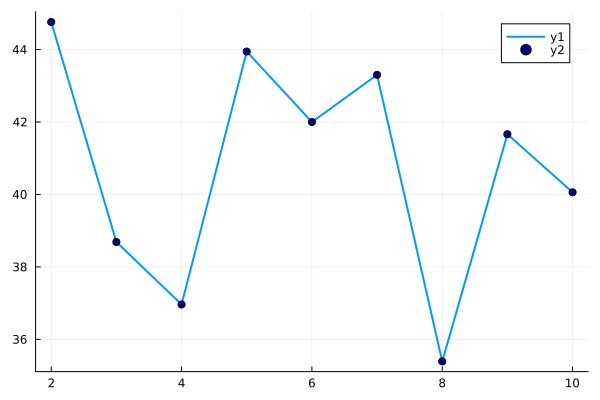

In [27]:
plot(performance_array[:,1], performance_array[:,2], lw=2)
scatter!(performance_array[:,1], performance_array[:,2], lw=2, c=:navy)